# Tutorial 3 : Attentive  (Conditional) Neural Processes 

Last Update : 27 August 2019

**Aim**: 
- Training a simple [Attentive Neural Process] (ANP) 
- See how well a ANP "learns" a GP kernel

**Nota Bene:**
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [ ]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [ ]:
cd ..

In [ ]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [ ]:
from utils.visualize import plot_dataset_samples_1d, plot_prior_samples_1d, plot_posterior_samples_1d, plot_losses
from ntbks_helpers import get_gp_datasets_varying # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 500 

datasets, test_datasets = get_gp_datasets_varying(n_samples=N_SAMPLES, n_points=N_POINTS)

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for important parameters. 

Main differences with [Tutorial 1 - Conditional Neural Process]:
- `AttentiveNeuralProcess` and `attention="transformer"` to use a cross attention as in [Image Transformer]. To replicate the paper you should use `attention="multihead"` (less parameters but converges a bit slower).
- To replicate the paper you should use `encoded_path="both"`, thus also using a latent path. 

Nota Bene:
- For this simpel artificial dataset, the paper doesn't use any self-attention. For more complicated (e.g. images in the paper), self-attention can be desirable. To do so, use `XYEncoder=merge_flat_input(SelfAttention, is_sum_merge=True)`.
- the model is very expressive and thus does not require 128 dim for the representation, I kept it to be comparable to the other ones.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb
[Image Transformer]: https://arxiv.org/abs/1802.05751

In [9]:
from functools import partial
from neuralproc import AttnLNP, AttnCNP
from ntbks_helpers import CNP_KWARGS # defined in first tutorial (CNP)
import torch.nn.functional as F

models = dict()

CNP_KWARGS.pop("encoded_path")
models["AttnCNP"] = partial(AttnCNP, X_DIM, Y_DIM, **CNP_KWARGS)
models["AttnLNP"] = partial(AttnLNP, X_DIM, Y_DIM, **CNP_KWARGS)

In [6]:
from utils.helpers import count_parameters

for k, model in models.items():
    print(k, "N Param:", count_parameters(model()))

AttnCNP N Param: 136898


/private/home/yannd/projects/NPF/neuralproc/architectures/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


TypeError: __init__() got multiple values for keyword argument 'encoded_path'

Using `"transformer"` attention increases the number of parameters, but using a deterministic path as well a smaller representation seize decreases the number of parameters.

## Training

The training procedure is the same as in [Tutorial 1 - Conditional Neural Process], refer to it for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [7]:
from neuralproc import CNPFLoss
from utils.train import train_models
from utils.data.dataloader import cntxt_trgt_collate
from ntbks_helpers import get_cntxt_trgt

In [24]:


trainers = train_models(
     datasets, 
     {"AttnCNP" : models["AttnCNP"]},
     CNPFLoss,
     test_datasets=test_datasets,
     chckpnt_dirname="results/notebooks/neural_process/", 
     is_retrain=True,  # load pretrained
     iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
     patience=10,
    max_epochs=20,
     seed=123) 


--- Training RBF_Kernel/AttnCNP/run_0 ---



  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      181.5288      174.0089     +  0.4394


      2      168.9845      168.8178     +  0.4060


      3      166.7106      171.6177        0.3800


      4      168.0778      160.7827     +  0.4738


      5      165.6193      161.1596        0.3922


      6      168.7726      164.5762        0.3978


      7      164.5313      171.0873        0.3960


      8      166.2830      158.7757     +  0.4178


      9      164.7474      169.2625        0.3957


     10      165.4551      163.9180        0.4928


     11      164.2146      167.9143        0.4072


     12      164.5709      165.4826        0.3860


     13      165.5822      178.1816        0.4326


     14      165.6246      164.7698        0.3845


     15      165.4849      154.5059     +  0.4886


     16      165.0770      166.7275        0.4819


     17      164.3975      155.7950        0.4129


     18      160.8600      170.7817        0.4088


     19      161.5783      161.1219        0.4064


     20      160.8729      159.4665        0.4850
Re-initializing module.
Re-initializing optimizer.


RBF_Kernel/AttnCNP/run_0 | best epoch: 15 | train loss: 164.2146 | valid loss: 154.5059 | test log likelihood: -163.0435

--- Training Periodic_Kernel/AttnCNP/run_0 ---



  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      182.4226      177.6460     +  0.3860


      2      173.8392      173.5343     +  0.4081


      3      171.5688      168.8883     +  0.4270


      4      171.0606      176.4365        0.4697


Re-initializing module.
Re-initializing optimizer.


KeyboardInterrupt: 

In [10]:
from neuralproc import NLLLossLNPF

trainers = train_models(
     datasets, 
     {"AttnLNP" : models["AttnLNP"]},
     NLLLossLNPF,
     test_datasets=test_datasets,
     chckpnt_dirname="results/notebooks/neural_process/", 
     is_retrain=True,  # load pretrained
     iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
     patience=10,
    max_epochs=20,
     seed=123) 


--- Training RBF_Kernel/AttnLNP/run_0 ---



/private/home/yannd/projects/NPF/neuralproc/architectures/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      182.7919      175.8896     +  0.9876


      2      167.7591      182.1157        0.7935


      3      166.9821      167.7857     +  0.7530


      4      163.3428      157.7062     +  0.7726


      5      163.5548      155.5911     +  0.7511


      6      163.8147      159.8849        0.7464


      7      160.7915      154.2428     +  0.8591


      8      159.0349      159.4129        0.7994


      9      158.3279      161.8154        0.8486


     10      160.6609      147.4428     +  0.8000


     11      160.2673      154.7104        0.8459


     12      158.4064      152.3087        0.7958


     13      157.8259      160.2736        0.7448


     14      153.4670      158.1948        0.7423


     15      154.5298      157.7938        0.8324


     16      157.5972      153.9218        0.7400


     17      157.0458      153.3239        0.8124


     18      150.9432      147.7873        0.7967


     19      149.5737      141.3418     +  0.7760


     20      151.9221      150.5294        0.8980
Re-initializing module.
Re-initializing optimizer.


RBF_Kernel/AttnLNP/run_0 | best epoch: 19 | train loss: 149.5737 | valid loss: 141.3418 | test log likelihood: -150.5134

--- Training Periodic_Kernel/AttnLNP/run_0 ---



  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      182.3841      174.8800     +  0.8191


      2      171.6517      170.7447     +  0.8168


      3      168.1323      163.1746     +  0.7477


Re-initializing module.
Re-initializing optimizer.


KeyboardInterrupt: 

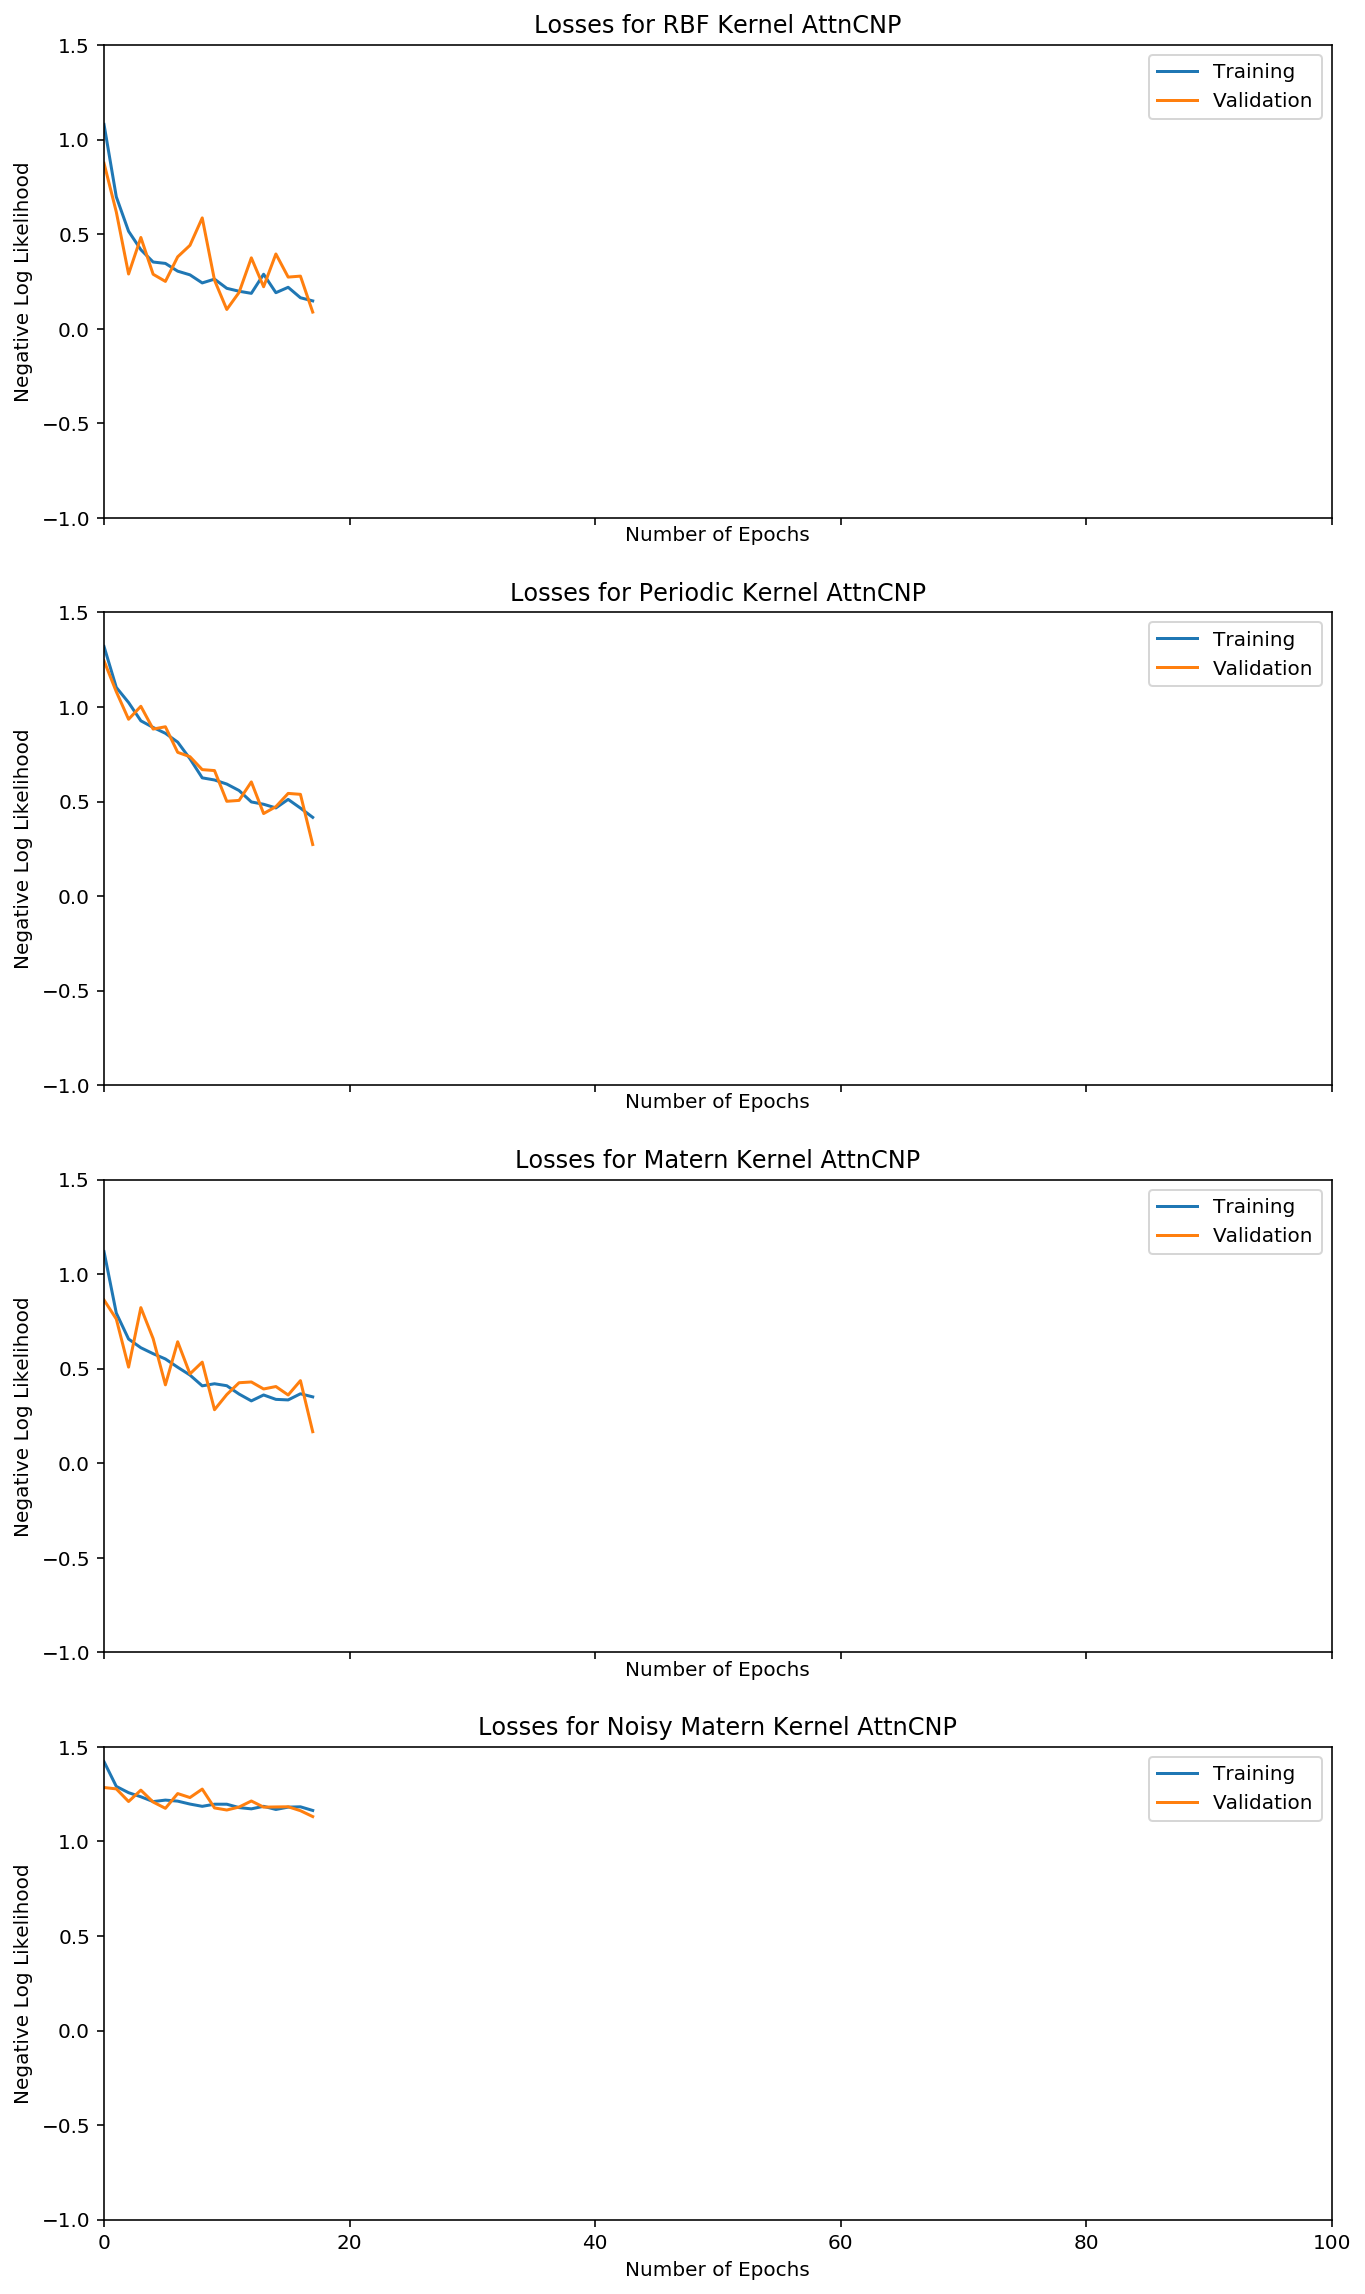

In [19]:
n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 1, figsize=(11, 5*n_datasets), sharex=True, sharey=True)
i = 0
for k, trainer in trainers.items():
    if "CNP" in k:
        plot_losses(trainer.history, 
                    title="Losses for {}".format(" ".join(k.split("/")).replace("_", " ")), 
                    ax=axes[i])
        axes[i].set_ylim([-1, 1.5])
        axes[i].set_xlim([0, 100])
        i += 1

# Inference


In [22]:
EXTRAP_DISTANCE = 4  # add 4 to the right for extrapolation
dataset = list(datasets.values())[0]
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

## Posterior

In [10]:
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs

def get_n_cntxt(n_cntxt):
    return CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=n_cntxt, max_n_indcs=n_cntxt),
                         targets_getter=get_all_indcs,
                         is_add_cntxts_to_trgts=False)

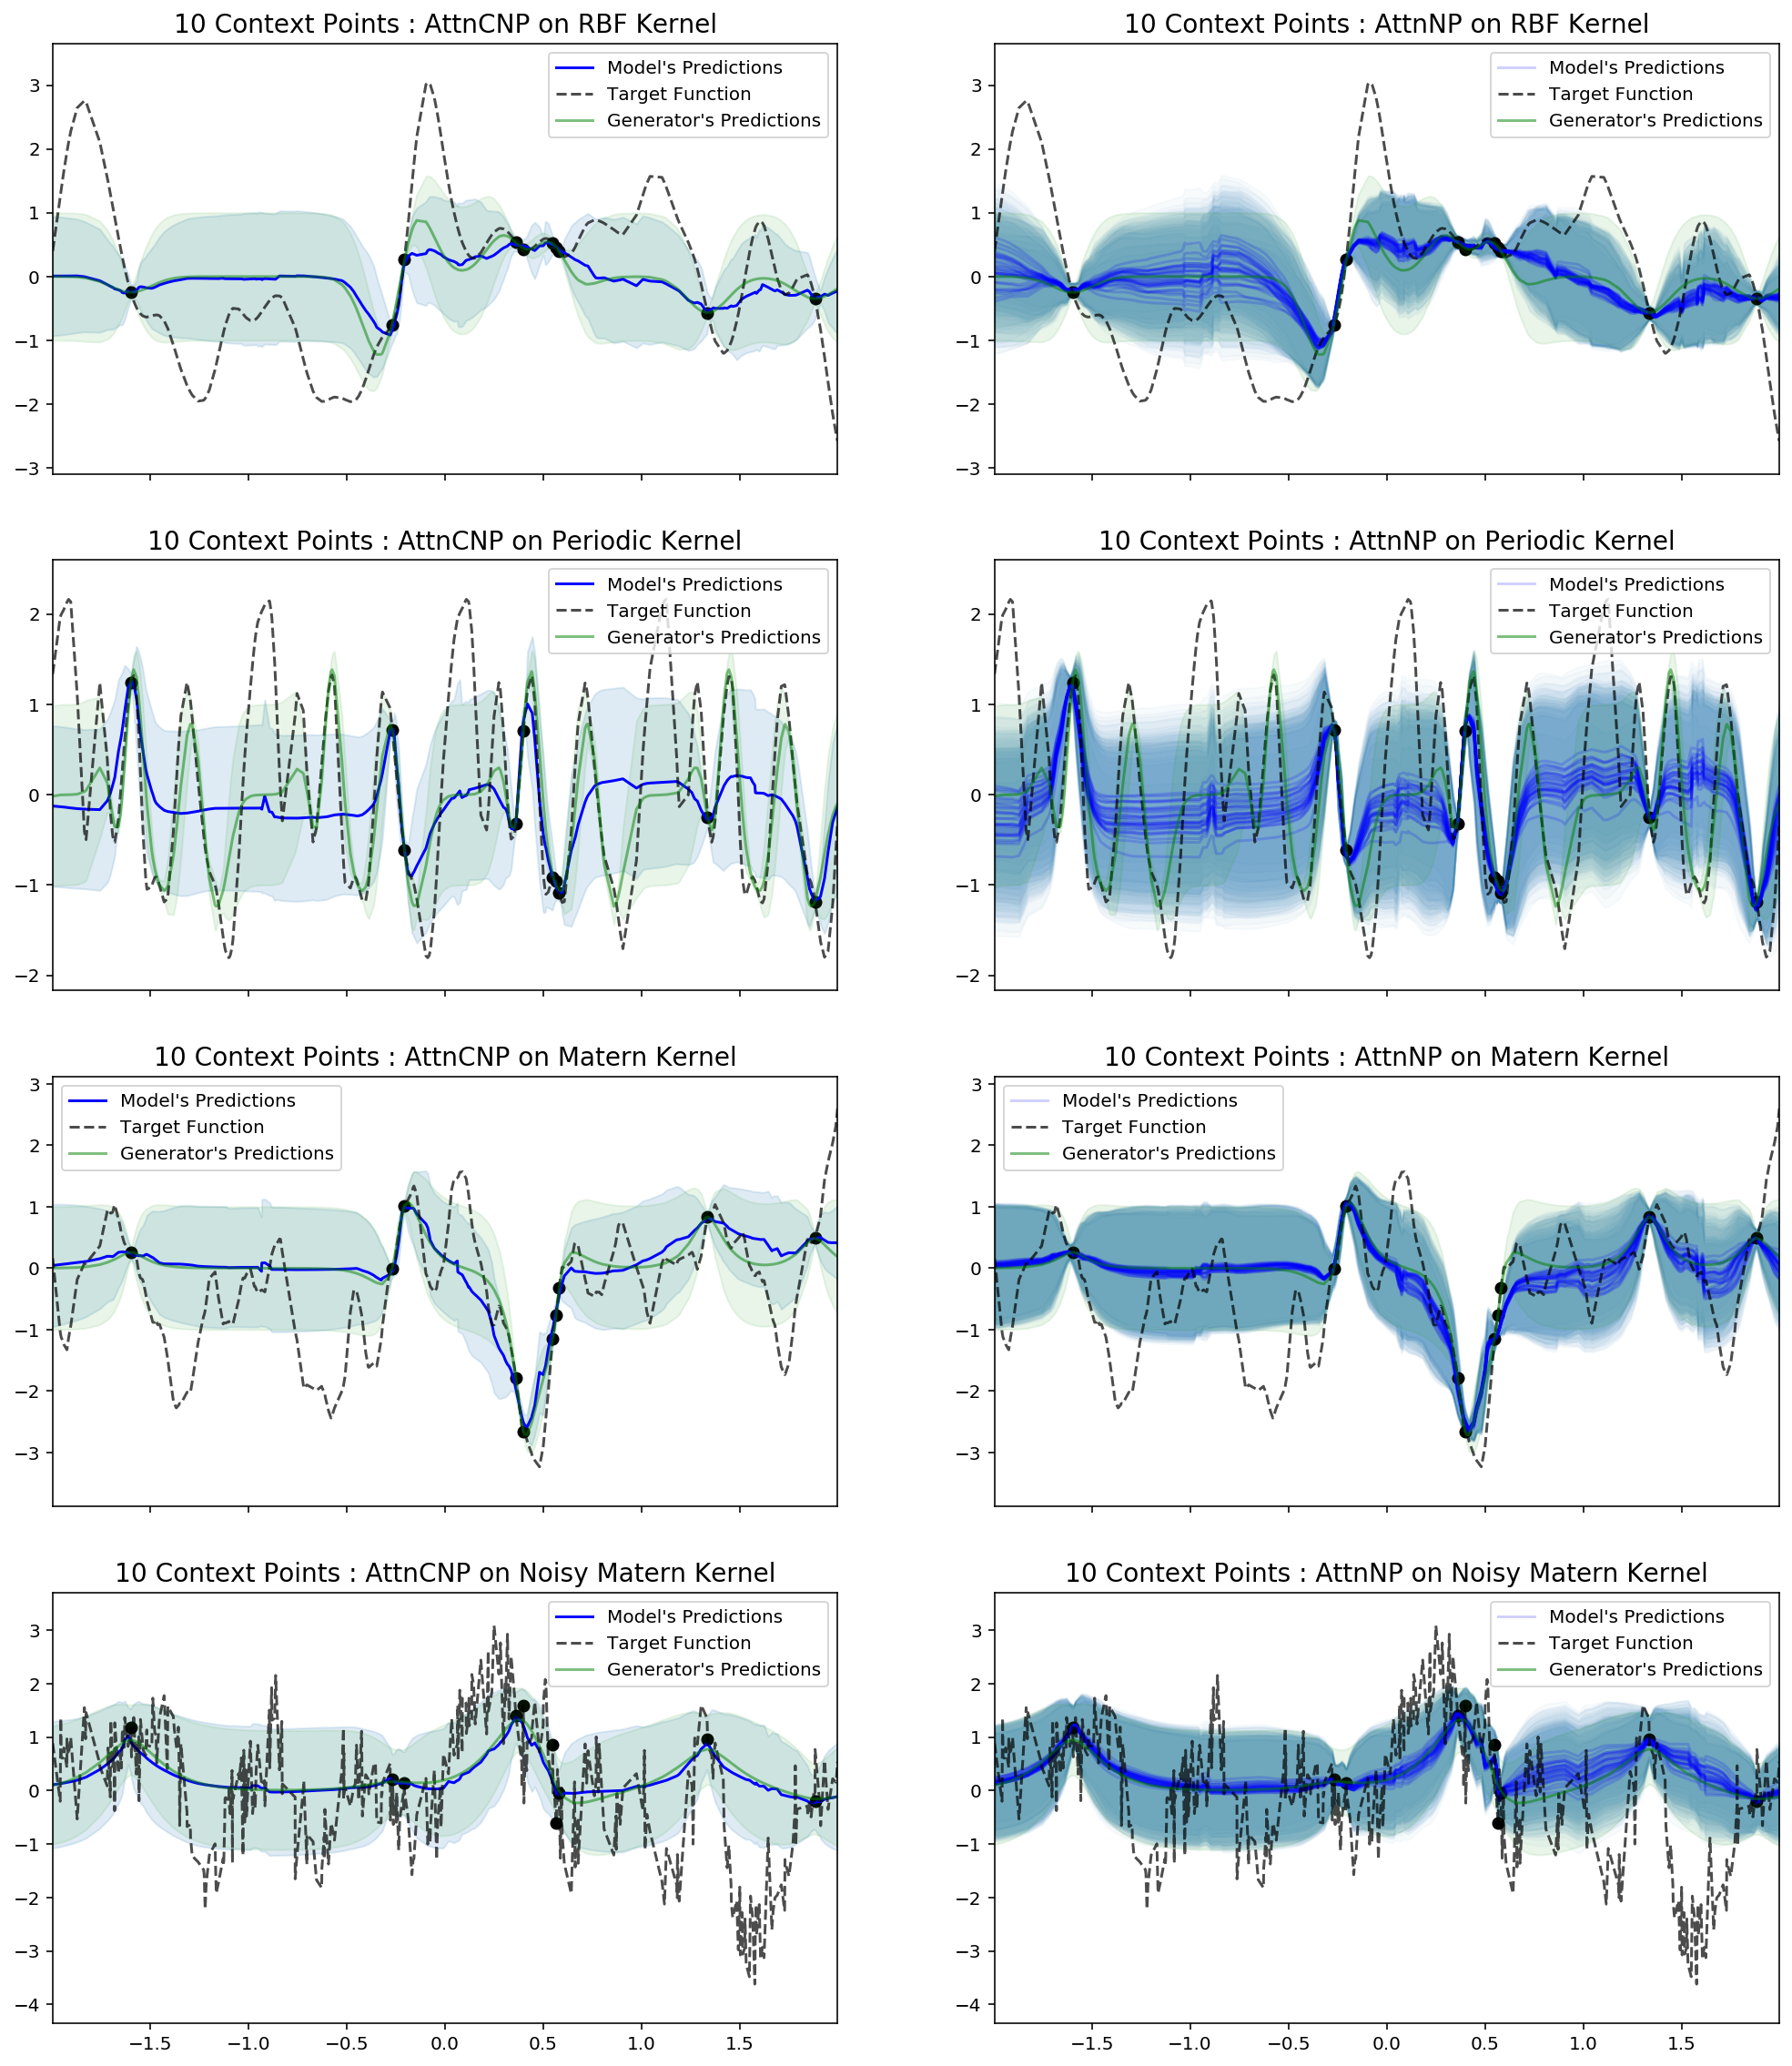

In [15]:
N_CNTXT = 10

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 2, figsize=(17, 5*n_datasets), sharex=True)

for i, (data_name, dataset) in enumerate(datasets.items()):
    dataset = datasets[data_name]
        
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS) # use higher density for plotting 

    for j, model_name in enumerate(models.keys()):
        plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainers[data_name + "/" + model_name].module_, 
                               generator=dataset.generator,
                               n_samples=1 if "CNP" in model_name else 30,
                               train_min_max=dataset.min_max,
                               is_plot_std=True,
                               title="{} Context Points : {} on {}".format(N_CNTXT, model_name, data_name.replace("_", " ")),
                               ax=axes[i,j],
                               seed = 123) # make sure smpling same cntxt / trgt

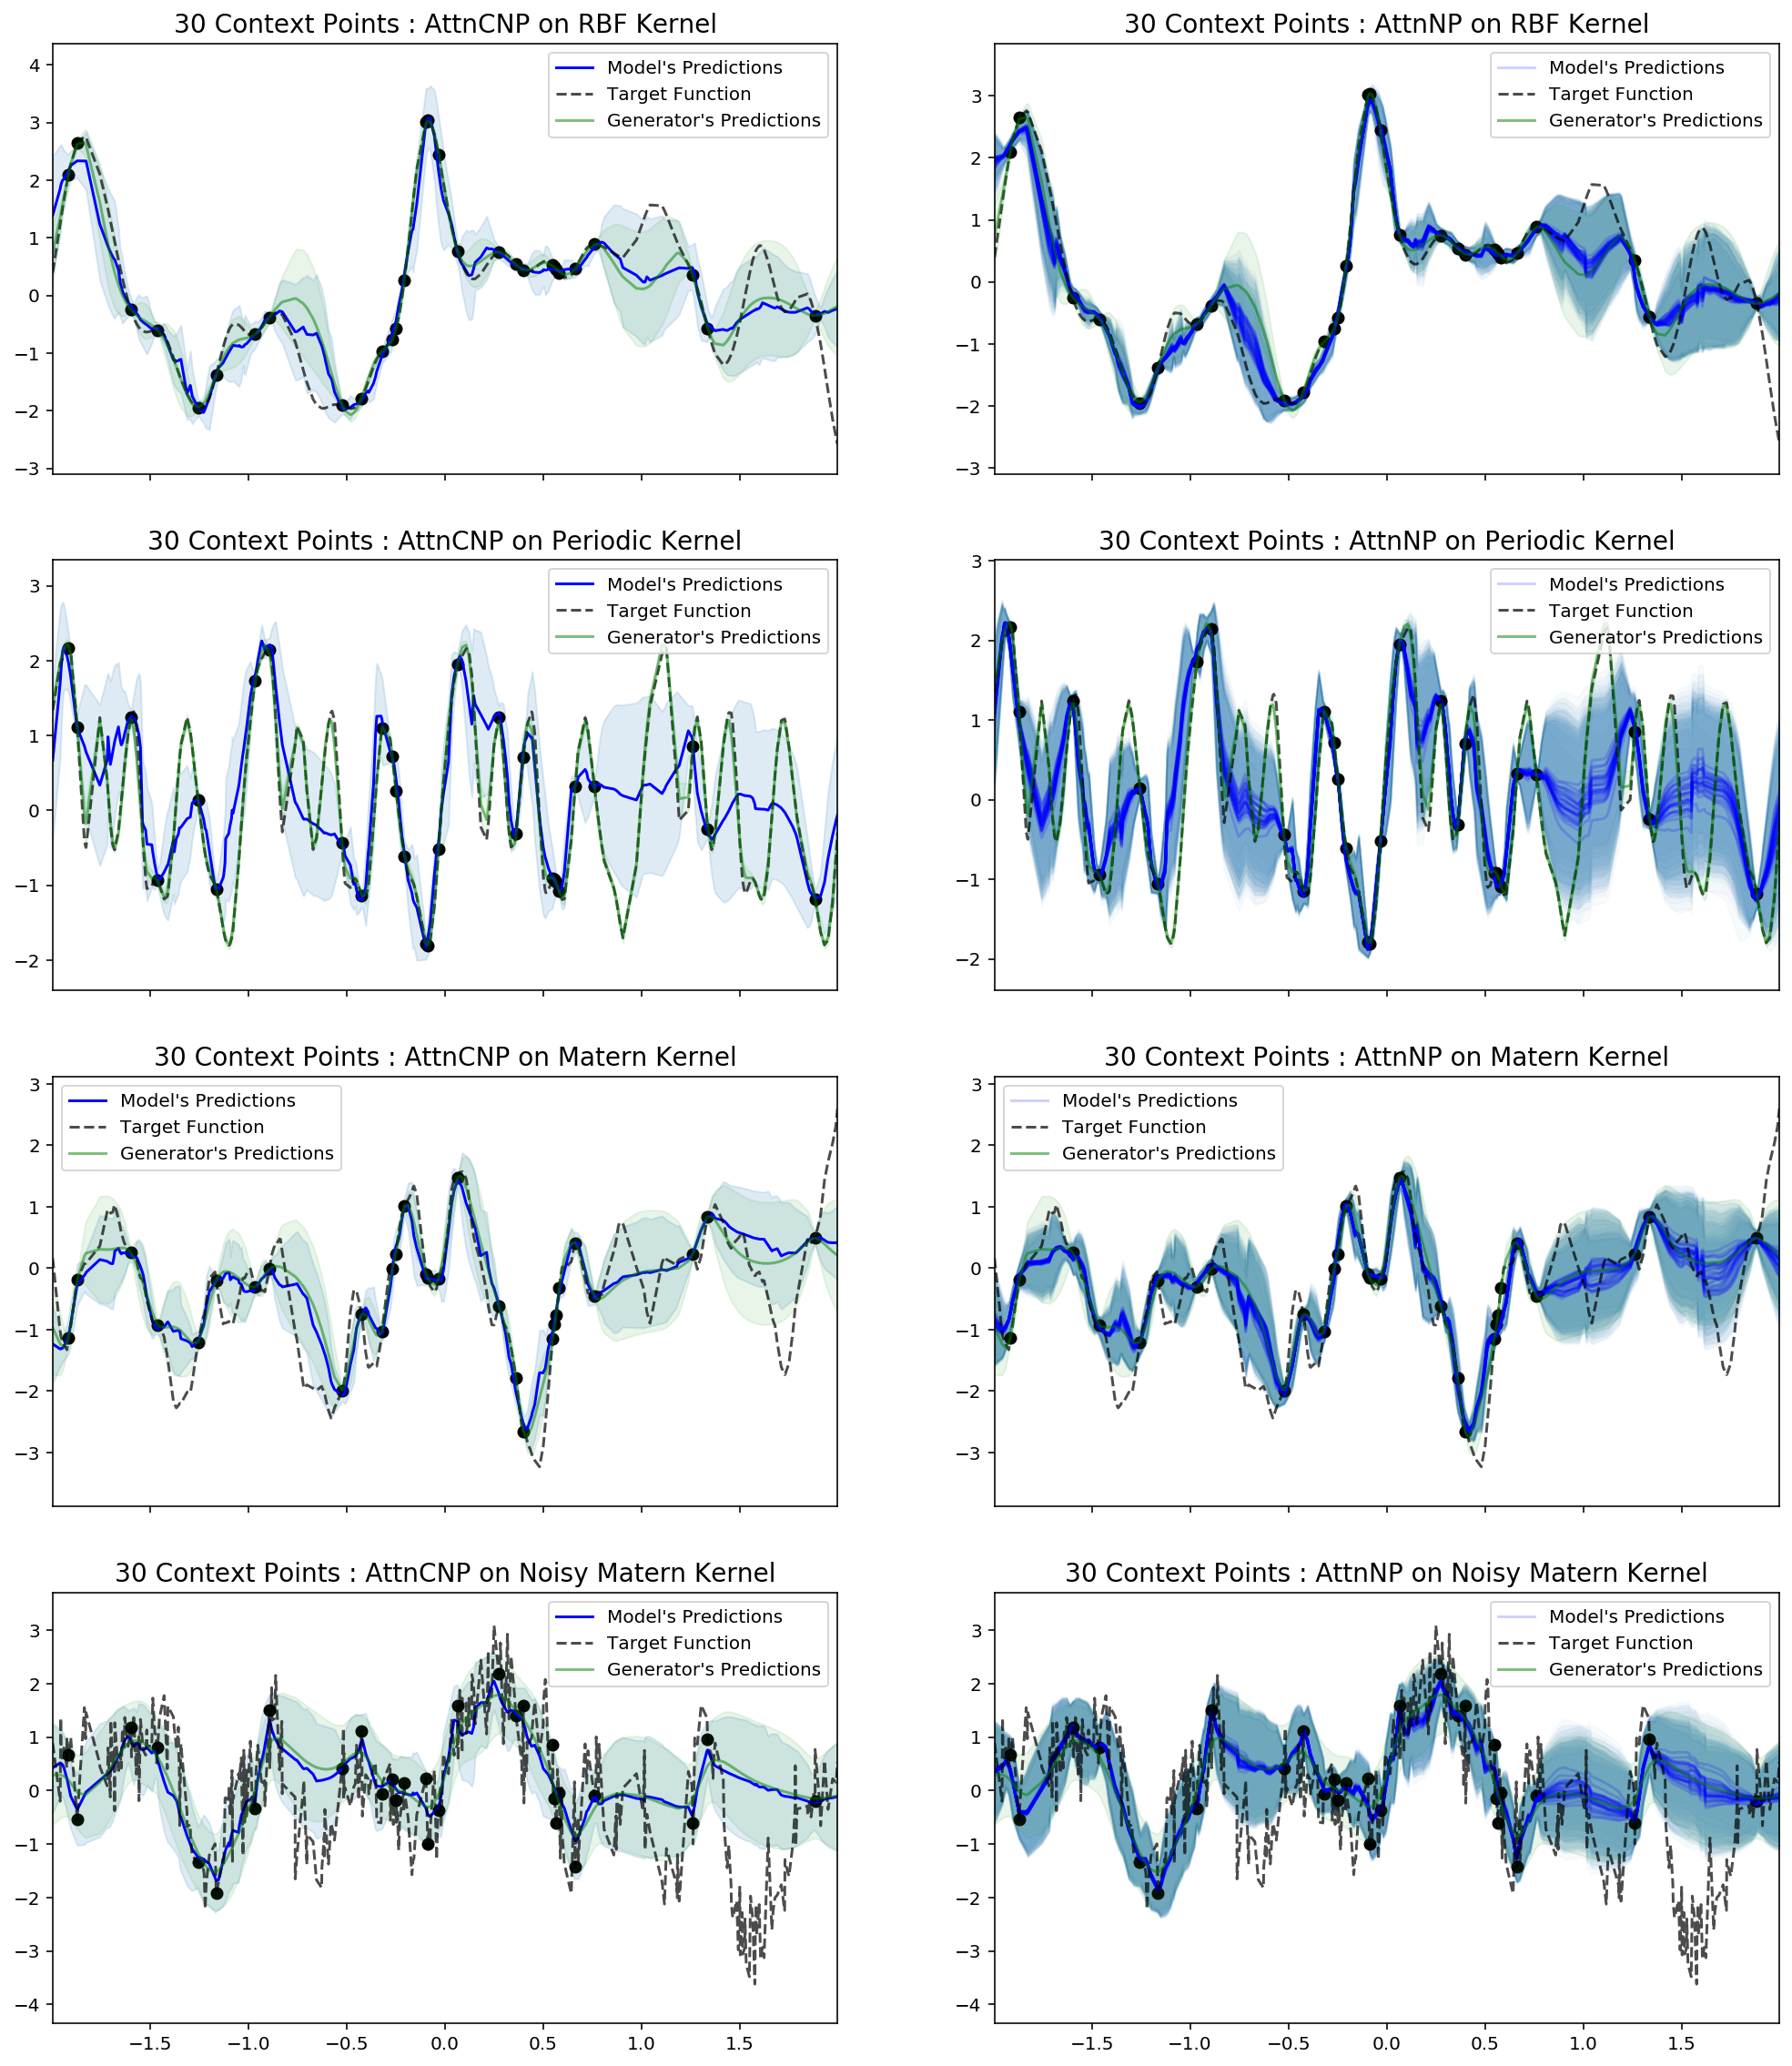

In [16]:
N_CNTXT = 30

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 2, figsize=(17, 5*n_datasets), sharex=True)

for i, (data_name, dataset) in enumerate(datasets.items()):
    dataset = datasets[data_name]
        
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS) # use higher density for plotting 

    for j, model_name in enumerate(models.keys()):
        plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainers[data_name + "/" + model_name].module_, 
                               generator=dataset.generator,
                               n_samples=1 if "CNP" in model_name else 30,
                               train_min_max=dataset.min_max,
                               is_plot_std=True,
                               title="{} Context Points : {} on {}".format(N_CNTXT, model_name, data_name.replace("_", " ")),
                               ax=axes[i,j],
                               seed = 123) # make sure smpling same cntxt / trgt

We see that the predictions are much better than in [Tutorial 2 - Neural Process]

**Good**:
- often close to GP with the correct kernel
- the uncertainty decreases close to context points
- no more underfitting : the sampled function all go through or close to the context points (besides when there's noise, which is the desired behavior)
- converges to very good results very fast

**Bad**:
- cannot extrapolate
- still not as smooth as GP
- not good at periodicity
- when using a latent path, the samples are not very different from each other

[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb

Although the predictions are very good, the model sufferes from a big drawback for many applications: it cannot extrapolate:

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00267001]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00267001]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.01049571]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  sta

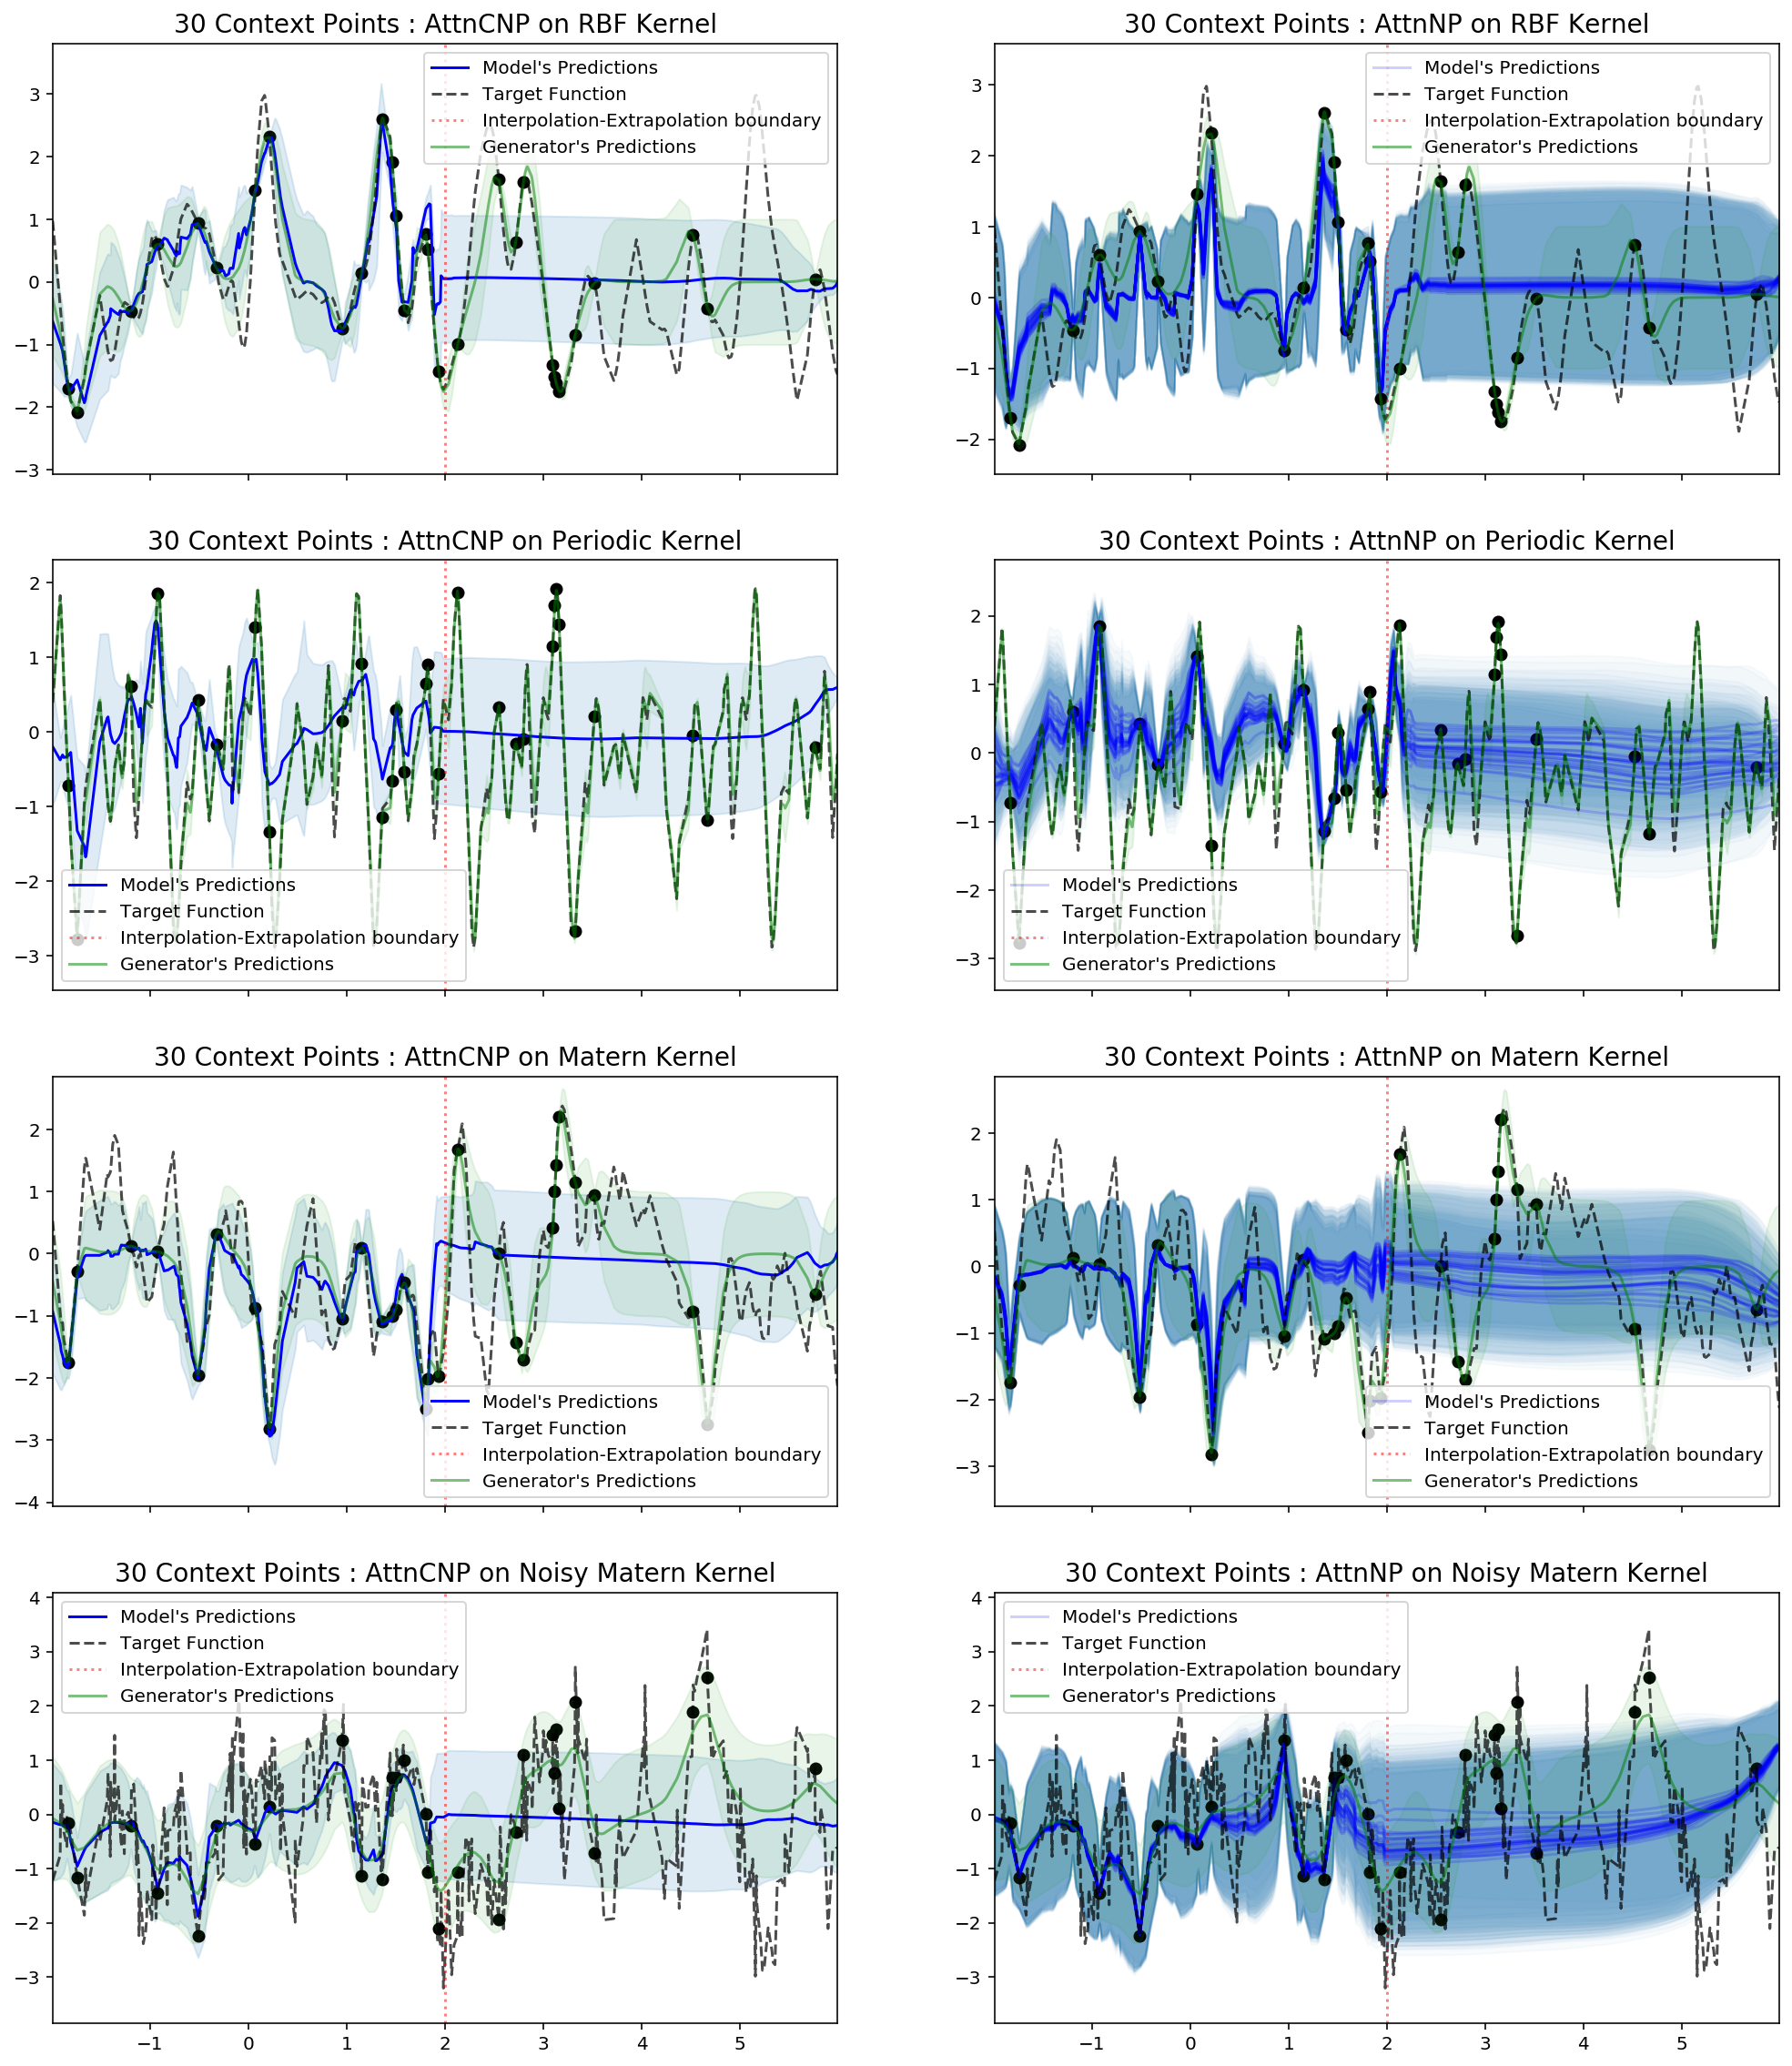

In [23]:
N_CNTXT = 30

n_datasets = len(datasets)
fig, axes = plt.subplots(n_datasets, 2, figsize=(17, 5*n_datasets), sharex=True)

for i, (data_name, dataset) in enumerate(datasets.items()):
    dataset = datasets[data_name]
        
    X, Y = dataset.get_samples(n_samples=1, 
                               n_points=3*N_POINTS,
                               test_min_max=EXTRAPOLATION_RANGE) 

    for j, model_name in enumerate(models.keys()):
        plot_posterior_samples_1d(X, Y, get_n_cntxt(N_CNTXT), trainers[data_name + "/" + model_name].module_, 
                               generator=dataset.generator,
                               n_samples=1 if "CNP" in model_name else 30,
                               train_min_max=dataset.min_max,
                               is_plot_std=True,
                               title="{} Context Points : {} on {}".format(N_CNTXT, model_name, data_name.replace("_", " ")),
                               ax=axes[i,j],
                               seed = 123) # make sure smpling same cntxt / trgt

In [20]:
import torch

import numpy as np
import skorch
import torch
import torch.nn as nn
import torch.nn.functional as F



In [21]:
def batch_flatten(x):
    """Batch wise flattenting of an array."""
    shape = x.shape
    return x.view(-1, shape[-1]), shape


def batch_unflatten(x, shape):
    """Revert `batch_flatten`."""
    return x.view(*shape[:-1], -1)

class BatchNorm1dLast(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.batch_norm = torch.nn.BatchNorm1d(*args, **kwargs)

    def forward(self, x):
        # flatten to make for normalizing layer => only 2 dim
        x, shape = batch_flatten(x)
        x = self.batch_norm(x)
        return batch_unflatten(x, shape)
    
def wrap_batchnorm(Module):
    # wrap a module by applying batchnorm1d to input
    class BatchNormWrapper(torch.nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self.batch_norm = BatchNorm1dLast(num_features=args[0], affine=False)
            self.module = Module(*args, **kwargs)

        def forward(self, x):
            x = self.batch_norm(x)
            return self.module(x)

    return BatchNormWrapper

In [22]:
Linearnorm = wrap_batchnorm(torch.nn.Linear)
model = Linearnorm(3,5)

In [23]:
model(torch.rand(10,3)).shape

torch.Size([10, 5])